In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
data_A = np.genfromtxt('data_final/DetectorA.csv', delimiter=',', skip_header=1).T
data_B = np.genfromtxt('data_final/DetectorB.csv', delimiter=',', skip_header=1).T
data_C = np.genfromtxt('data_final/DetectorC.csv', delimiter=',', skip_header=1).T
data_Target = np.genfromtxt('data_final/DetectorTarget.csv', delimiter=',', skip_header=1).T

In [3]:
# Score
score_A = data_A[1]
score_B = data_B[1]
score_C = data_C[1]
score_Target = data_Target[1]

# Energy
energy_A = data_A[2]
energy_B = data_B[2]
energy_C = data_C[2]
energy_Target = data_Target[2]


In [4]:
# Set limits
energy_upper_limit = 3500
energy_lower_limit = 1000

score_A = score_A[energy_A < energy_upper_limit]
score_B = score_B[energy_B < energy_upper_limit]
score_C = score_C[energy_C < energy_upper_limit]
score_Target = score_Target[energy_Target < energy_upper_limit]

energy_A = energy_A[energy_A < energy_upper_limit]
energy_B = energy_B[energy_B < energy_upper_limit]
energy_C = energy_C[energy_C < energy_upper_limit]
energy_Target = energy_Target[energy_Target < energy_upper_limit]

(1000.0, 3505.0)

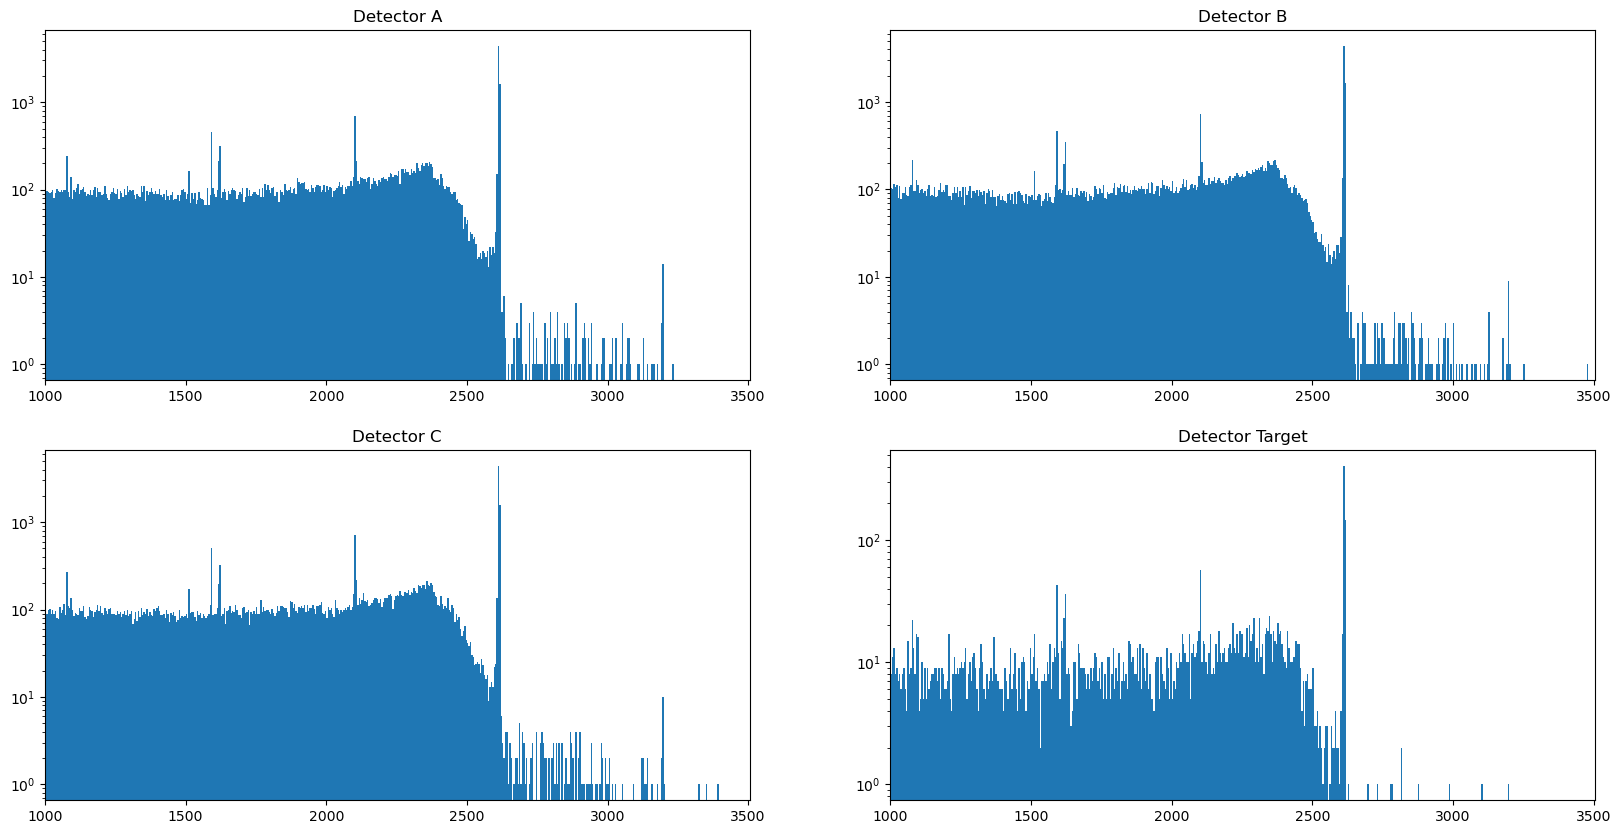

In [5]:
# Create histograms
# n_bins = 500
bin_width = 5
hist_A, bins_A = np.histogram(energy_A, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))
hist_B, bins_B = np.histogram(energy_B, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))
hist_C, bins_C = np.histogram(energy_C, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))
hist_Target, bins_Target = np.histogram(energy_Target, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0, 0].set_title('Detector A')
axes[0, 0].stairs(hist_A, bins_A, label='Detector A', fill=True)
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlim(energy_lower_limit, energy_upper_limit + bin_width)

axes[0, 1].set_title('Detector B')
axes[0, 1].stairs(hist_B, bins_B, label='Detector B', fill=True)
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlim(energy_lower_limit, energy_upper_limit + bin_width)

axes[1, 0].set_title('Detector C')
axes[1, 0].stairs(hist_C, bins_C, label='Detector C', fill=True)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlim(energy_lower_limit, energy_upper_limit + bin_width)

axes[1, 1].set_title('Detector Target')
axes[1, 1].stairs(hist_Target, bins_Target, label='Detector Target', fill=True)
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlim(energy_lower_limit, energy_upper_limit + bin_width)


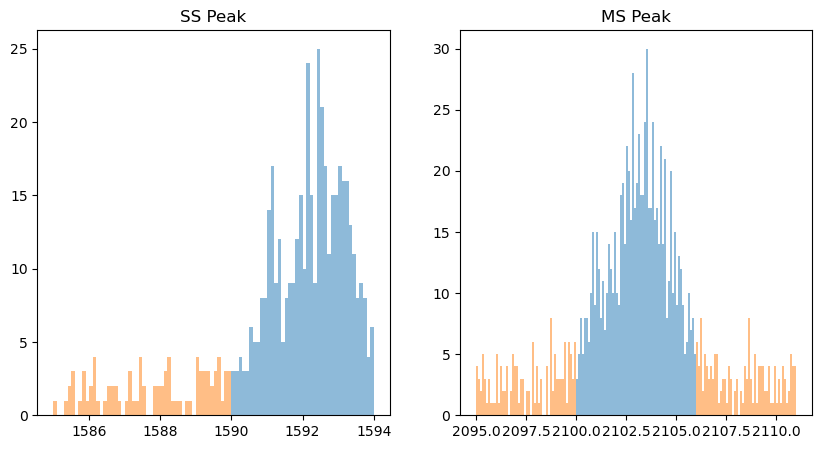

In [6]:
# Range of SS peak
ss_lower_limit = 1590
ss_upper_limit = 1594

# Range of MS peak
ms_lower_limit = 2100
ms_upper_limit = 2106

# Range of SS baseline
ss_baseline_lower_limit = 1585

# Range of MS baseline
ms_baseline_lower_limit = 2095
ms_baseline_upper_limit = 2111

ss = energy_A[(energy_A > ss_lower_limit) & (energy_A < ss_upper_limit)]
ms = energy_B[(energy_B > ms_lower_limit) & (energy_B < ms_upper_limit)]

ss_baseline = energy_A[(energy_A > ss_baseline_lower_limit) & (energy_A < ss_lower_limit)]
ms_baseline = energy_B[((energy_B > ms_baseline_lower_limit) & (energy_B < ms_lower_limit)) | ((energy_B > ms_upper_limit) & (energy_B < ms_baseline_upper_limit))]

bin_width_peaks = 0.1

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title('SS Peak')
_ = axes[0].hist(ss, bins=np.arange(ss_lower_limit, ss_upper_limit + bin_width_peaks, bin_width_peaks), alpha=0.5, label='Peak')
_ = axes[0].hist(ss_baseline, bins=np.arange(ss_baseline_lower_limit, ss_lower_limit + bin_width_peaks, bin_width_peaks), alpha=0.5, label='Baseline')

axes[1].set_title('MS Peak')
_ = axes[1].hist(ms, bins=np.arange(ms_lower_limit, ms_upper_limit + bin_width_peaks, bin_width_peaks), alpha=0.5, label='Peak')
_ = axes[1].hist(ms_baseline, bins=np.arange(ms_baseline_lower_limit, ms_baseline_upper_limit + bin_width_peaks, bin_width_peaks), alpha=0.5, label='Baseline')

In [7]:
ss_score = score_A[(energy_A > ss_lower_limit) & (energy_A < ss_upper_limit)]
ms_score = score_B[(energy_B > ms_lower_limit) & (energy_B < ms_upper_limit)]

ss_baseline_score = score_A[(energy_A > ss_baseline_lower_limit) & (energy_A < ss_lower_limit)]
ms_baseline_score = score_B[((energy_B > ms_baseline_lower_limit) & (energy_B < ms_lower_limit)) | ((energy_B > ms_upper_limit) & (energy_B < ms_baseline_upper_limit))]

Ns = ss.size
Bs = ss_baseline.size
Nb = ms.size
Bb = ms_baseline.size

# Return TPR, FPR
def metrics(threshold, tau_ss=1, tau_ms=0.5):
    Ntp = np.sum(ss_score > threshold)
    Bss = np.sum(ss_baseline_score > threshold)
    Nfp = np.sum(ms_score > threshold)
    Bms = np.sum(ms_baseline_score > threshold)
    return (Ntp - tau_ss * Bss) / (Ns - tau_ss * Bs), (Nfp - tau_ms * Bms) / (Nb - tau_ms * Bb)

# Try n thresholds
def roc(n=200):
    return np.array([metrics(t) for t in np.linspace(0, 1, n)])

# Plot ROC curve
def plot_roc(threshold):
    roc_curve = roc()
    selected = metrics(threshold)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(roc_curve[:, 1], roc_curve[:, 0], label='ROC curve')
    ax.plot(selected[1], selected[0], 'ro', label='Selected threshold')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    print(f'Selected threshold: {threshold:.3f}')
    print(f'True positive rate: {selected[0]:.2f}')
    print(f'False positive rate: {selected[1]:.2f}')
    plt.legend()

In [8]:
import ipywidgets as widgets

widgets.interact(plot_roc, 
         threshold=widgets.FloatSlider(min=0, max=1, step=0.005, value=0.5, layout=widgets.Layout(width='50%')))

interactive(children=(FloatSlider(value=0.5, description='threshold', layout=Layout(width='50%'), max=1.0, ste…

<function __main__.plot_roc(threshold)>

In [9]:
# Final selection
selected_threshold = 0.085

selected_energy_A = energy_A[score_A > selected_threshold]
selected_energy_B = energy_B[score_B > selected_threshold]
selected_energy_C = energy_C[score_C > selected_threshold]
selected_energy_Target = energy_Target[score_Target > selected_threshold]

selected_hist_A, selected_bins_A = np.histogram(selected_energy_A, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))
selected_hist_B, selected_bins_B = np.histogram(selected_energy_B, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))
selected_hist_C, selected_bins_C = np.histogram(selected_energy_C, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))
selected_hist_Target, selected_bins_Target = np.histogram(selected_energy_Target, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))

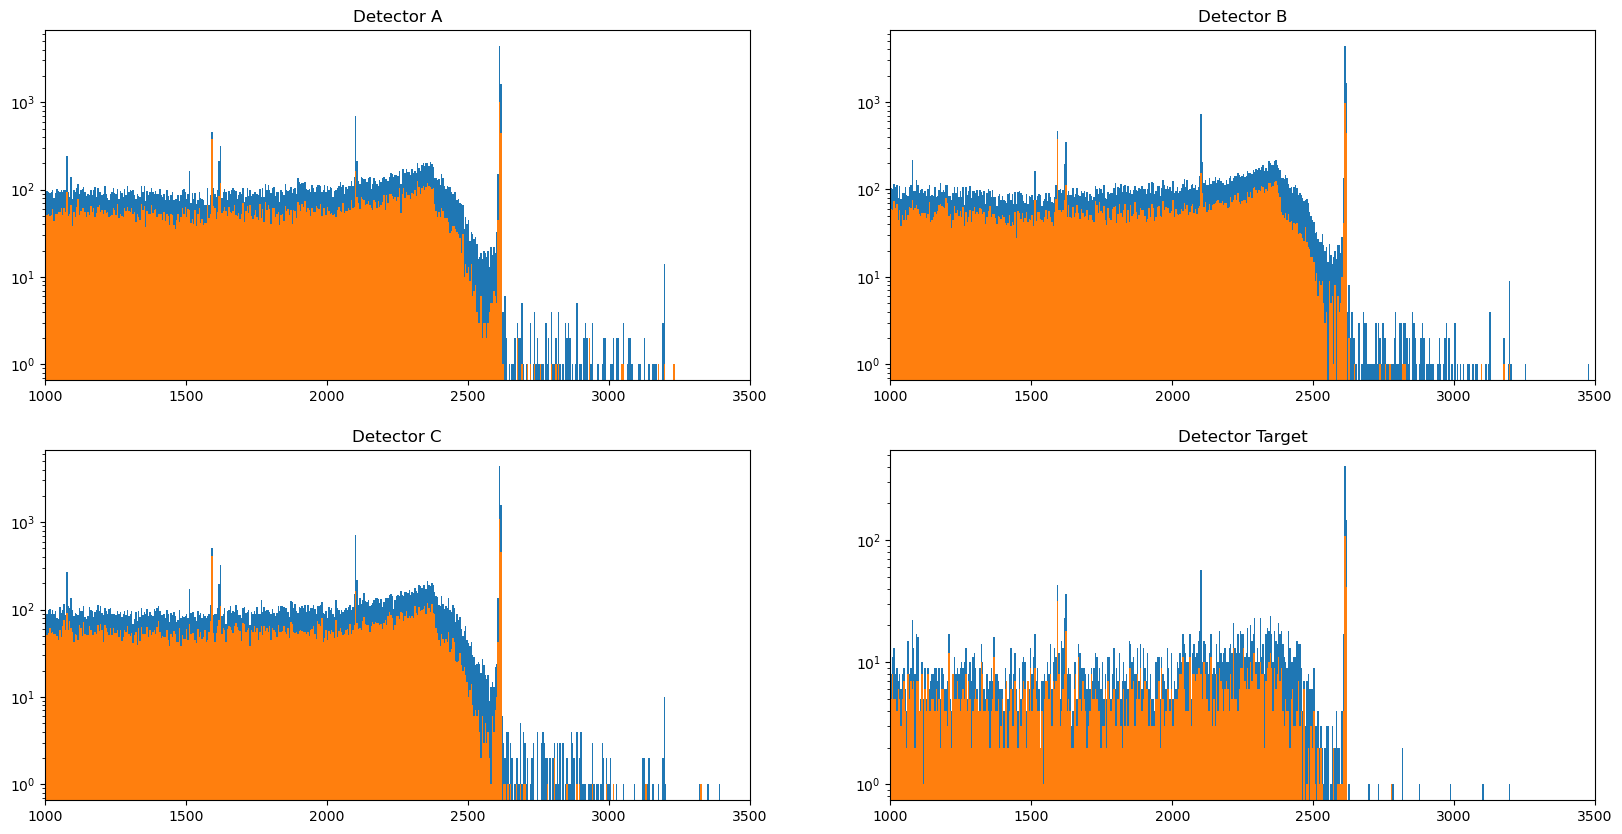

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0, 0].set_title('Detector A')
axes[0, 0].stairs(hist_A, bins_A, label='Detector A', fill=True)
axes[0, 0].stairs(selected_hist_A, selected_bins_A, label='Detector A', fill=True)
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlim(energy_lower_limit, energy_upper_limit)

axes[0, 1].set_title('Detector B')
axes[0, 1].stairs(hist_B, bins_B, label='Detector B', fill=True)
axes[0, 1].stairs(selected_hist_B, selected_bins_B, label='Detector B', fill=True)
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlim(energy_lower_limit, energy_upper_limit)

axes[1, 0].set_title('Detector C')
axes[1, 0].stairs(hist_C, bins_C, label='Detector C', fill=True)
axes[1, 0].stairs(selected_hist_C, selected_bins_C, label='Detector C', fill=True)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlim(energy_lower_limit, energy_upper_limit)

axes[1, 1].set_title('Detector Target')
axes[1, 1].stairs(hist_Target, bins_Target, label='Detector Target', fill=True)
axes[1, 1].stairs(selected_hist_Target, selected_bins_Target, label='Detector Target', fill=True)
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlim(energy_lower_limit, energy_upper_limit)

plt.show()


In [11]:
# Gaussian function
def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

# Generate NLDBD PDF
mu = 2039
sigma = 1
bins_N = np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width)
pdf_N = gaussian((bins_N[:-1] + bins_N[1:]) / 2, mu, sigma)
pdf_N /= np.sum(pdf_N)  # Normalize

In [12]:
sum(pdf_N)

1.0

In [13]:
# Normalize histograms to get PDFs
pdf_A = selected_hist_A / np.sum(selected_hist_A)
pdf_B = selected_hist_B / np.sum(selected_hist_B)
pdf_C = selected_hist_C / np.sum(selected_hist_C)

In [14]:
sum(pdf_A), sum(pdf_B), sum(pdf_C)

(1.0, 0.9999999999999993, 1.0000000000000004)

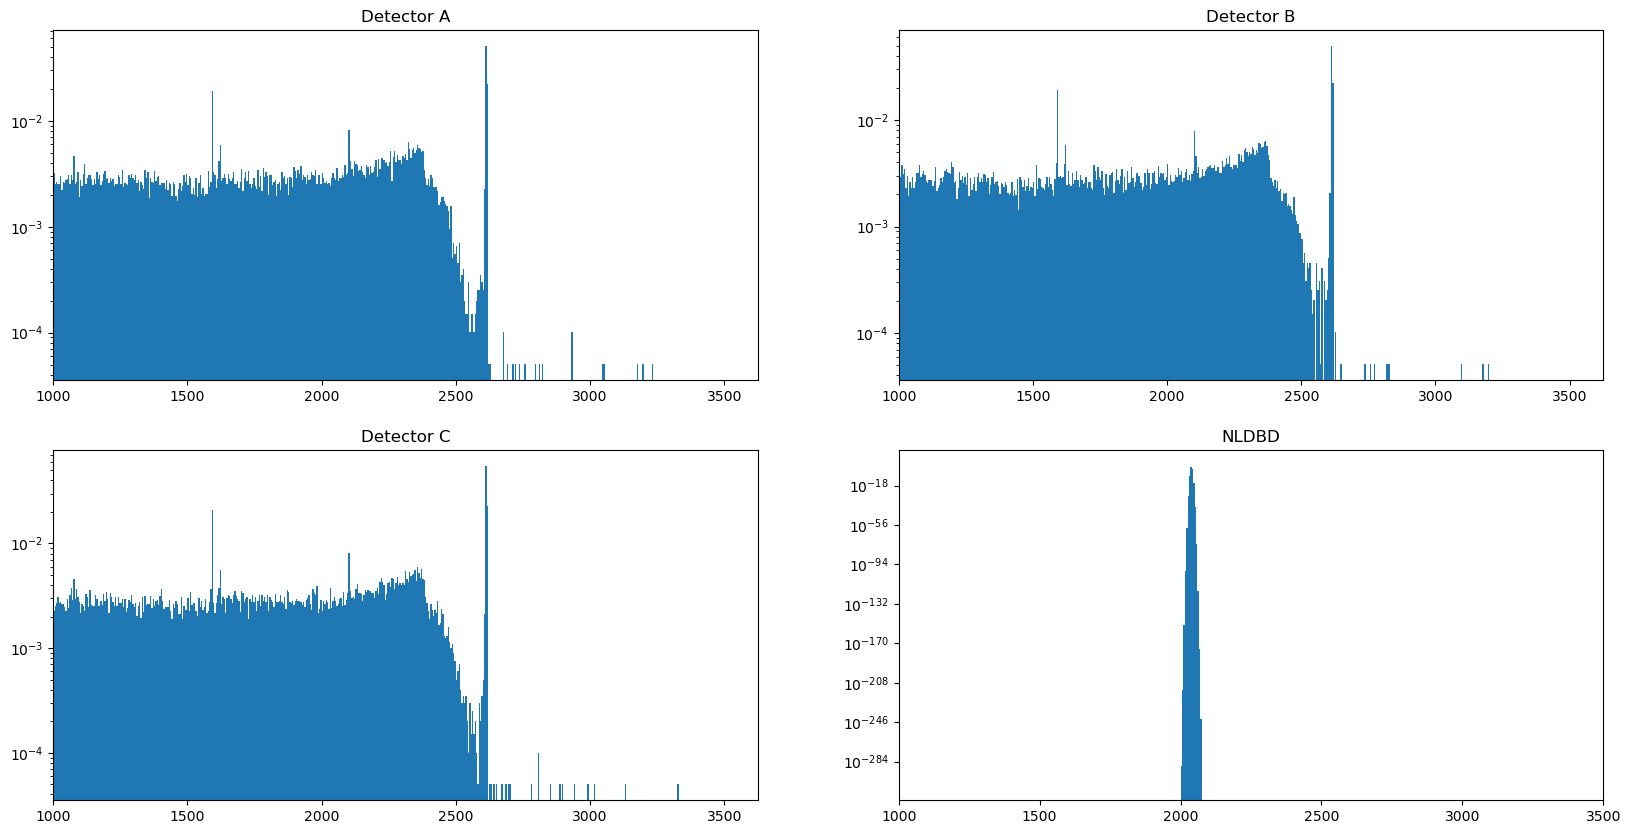

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[0, 0].set_title('Detector A')
axes[0, 0].stairs(pdf_A, bins_A, label='Detector A', fill=True)
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlim(1000)

axes[0, 1].set_title('Detector B')
axes[0, 1].stairs(pdf_B, bins_B, label='Detector B', fill=True)
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlim(1000)

axes[1, 0].set_title('Detector C')
axes[1, 0].stairs(pdf_C, bins_C, label='Detector C', fill=True)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlim(1000)

axes[1, 1].set_title('NLDBD')
axes[1, 1].stairs(pdf_N, bins_N, label='NLDBD', fill=True)
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlim(1000, energy_upper_limit)

plt.show()

In [16]:
# theta = [theta_A, theta_B, theta_C, theta_N]
def hypothesis(theta):
    return theta[0] * pdf_A + theta[1] * pdf_B + theta[2] * pdf_C + theta[3] * pdf_N

def log_likelihood(theta, target_hist):
    mu = hypothesis(theta)
    non_zero_bins = target_hist[(target_hist > 0) & (mu > 0)]
    non_zero_bins_mu = mu[(target_hist > 0) & (mu > 0)]
    zero_bins_mu = mu[~(target_hist > 0) & ~(mu > 0)]
        
    return np.sum(non_zero_bins * np.log(non_zero_bins_mu) - non_zero_bins_mu - non_zero_bins * np.log(non_zero_bins) + non_zero_bins) - np.sum(zero_bins_mu)

def log_prior(theta):
    # Use Gaussian prior for theta_A and theta_B, Jeffreys prior for Poisson distribution for theta_C and theta_N
    prior = np.log(gaussian(theta[0], 1350, 100)) + np.log(gaussian(theta[1], 770, 270)) - np.log(theta[2]) / 2 - np.log(theta[3]) / 2
    return prior

def log_posterior(theta, target_hist):
    # Use the log-likelihood and log-prior to compute the log-posterior
    posterior = log_likelihood(theta, target_hist) + log_prior(theta)
    if np.any(theta < 0):
        return -np.inf
    return posterior

def acquisition_function(theta):
    # TODO
    pass

In [17]:
sum(selected_hist_Target)

1838

In [36]:
theta_min = 0
theta_max = 3000

In [50]:
from scipy.optimize import minimize

theta_initial = np.array([1350, 770, 1000, 1000])
theta_est = minimize(lambda theta: -log_posterior(theta, selected_hist_Target), theta_initial, bounds=[(0, 3000), (0, 3000), (0, 3000), (0, 3000)]).x


/tmp/ipykernel_499/928682982.py:15: RuntimeWarning: divide by zero encountered in log
  prior = np.log(gaussian(theta[0], 1350, 100)) + np.log(gaussian(theta[1], 770, 270)) - np.log(theta[2]) / 2 - np.log(theta[3]) / 2


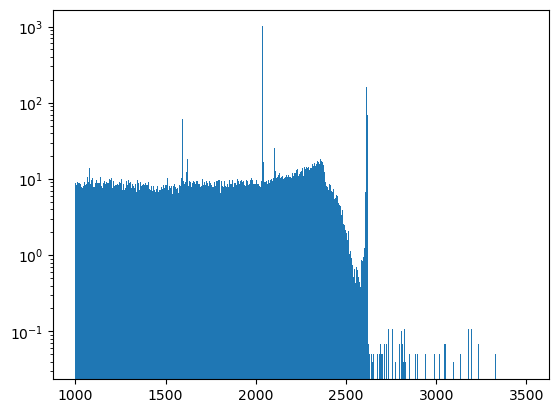

In [38]:
plt.stairs(hypothesis(theta_initial), bins_Target, label='Hypothesis', fill=True)
plt.yscale('log')

In [39]:
theta_est

array([1349.59022283,  769.59245575,  999.59252396,  999.01283523])

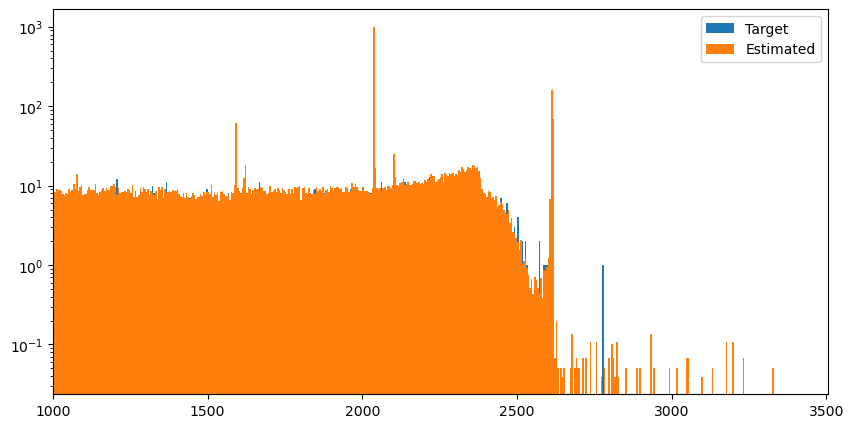

In [40]:
result_hist = hypothesis(theta_est)
plt.figure(figsize=(10, 5))
plt.stairs(selected_hist_Target, bins_Target, label='Target', fill=True)
plt.stairs(result_hist, bins_Target, label='Estimated', fill=True)
plt.yscale('log')
plt.xlim(energy_lower_limit, energy_upper_limit + bin_width)
plt.legend()


In [41]:
TPR = metrics(selected_threshold)[0]
theta_est[3] / TPR

1112.9068066773893

In [56]:
import emcee

n_walkers = 100
initial_theta = theta_est + 0.1 * np.random.randn(n_walkers, len(theta_est))

sampler = emcee.EnsembleSampler(n_walkers, len(theta_est), log_posterior, args=[selected_hist_Target])

In [25]:
sampler.run_mcmc(initial_theta, 5000, progress=True)

  1%|          | 28/5000 [00:00<00:37, 132.54it/s]/tmp/ipykernel_499/928682982.py:15: RuntimeWarning: invalid value encountered in log
  prior = np.log(gaussian(theta[0], 1350, 100)) + np.log(gaussian(theta[1], 770, 270)) - np.log(theta[2]) / 2 - np.log(theta[3]) / 2
100%|██████████| 5000/5000 [00:36<00:00, 138.32it/s]


State([[1.22208196e+03 5.89287067e+02 3.43280663e+01 3.69254801e+00]
 [1.17223429e+03 2.92297118e+02 4.02163431e+02 4.77129569e+00]
 [1.24465428e+03 3.54696808e+02 2.13182171e+02 6.40586159e+00]
 [1.13334383e+03 5.74121421e+02 1.22414919e+02 3.16693263e+00]
 [1.30466706e+03 3.73610521e+02 2.34842889e+02 1.31891546e+00]
 [1.24735115e+03 4.00138188e+02 1.35615011e+02 5.26120256e+00]
 [1.31606101e+03 2.14077677e+02 3.85434066e+02 4.44554067e+00]
 [1.29365754e+03 5.24501102e+02 1.41648359e-01 7.69093671e+00]
 [1.21726890e+03 7.15210227e+02 1.34058810e+01 8.27512873e+00]
 [1.13211932e+03 6.19006883e+02 1.18714609e+02 3.43544666e+00]
 [1.26449517e+03 5.02963058e+02 5.68413741e+01 1.10389170e+00]
 [1.42039147e+03 3.65638334e+02 6.07277524e+01 3.42994585e+00]
 [1.33808057e+03 4.39887906e+02 3.43373831e+01 7.40280819e+00]
 [1.24069404e+03 5.70716410e+02 2.74632488e+01 7.67517008e+00]
 [1.14880810e+03 3.31618102e+02 3.49687659e+02 7.90564895e+00]
 [1.17217080e+03 5.78150457e+02 1.31231516e+02 4.

Text(0.5, 0, 'step number')

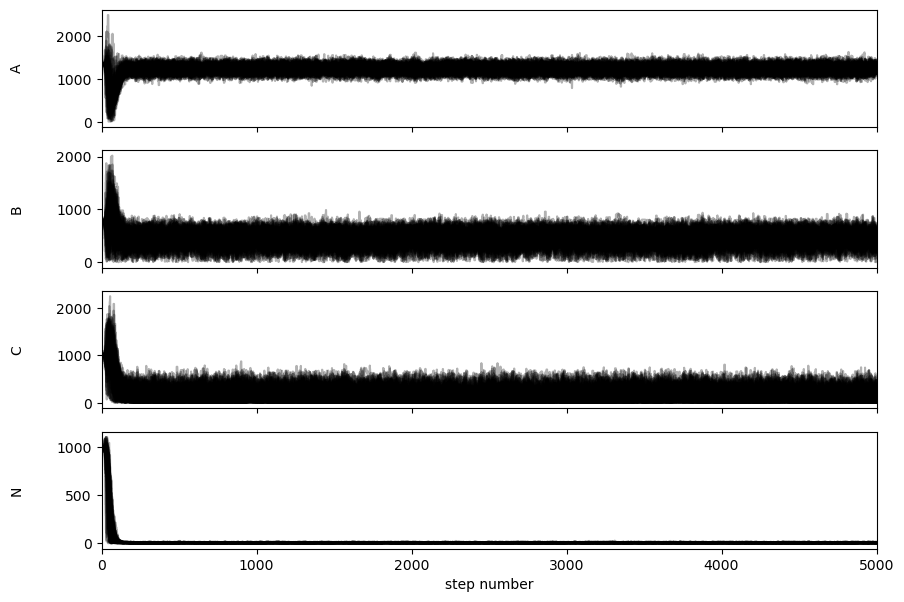

In [26]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "B", "C", "N"]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [27]:
tau = sampler.get_autocorr_time()
print(tau)

[57.323437   64.81782632 86.69626044 60.9201712 ]


In [28]:
flat_samples = sampler.get_chain(discard=200, flat=True)
print(flat_samples.shape)

(480000, 4)


In [29]:
from IPython.display import display, Math

result = []
for i in range(4):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    result.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [30]:
result

[1235.4646954973127, 490.54563337065804, 115.19408459042025, 5.257016639428169]

(1000.0, 3505.0)

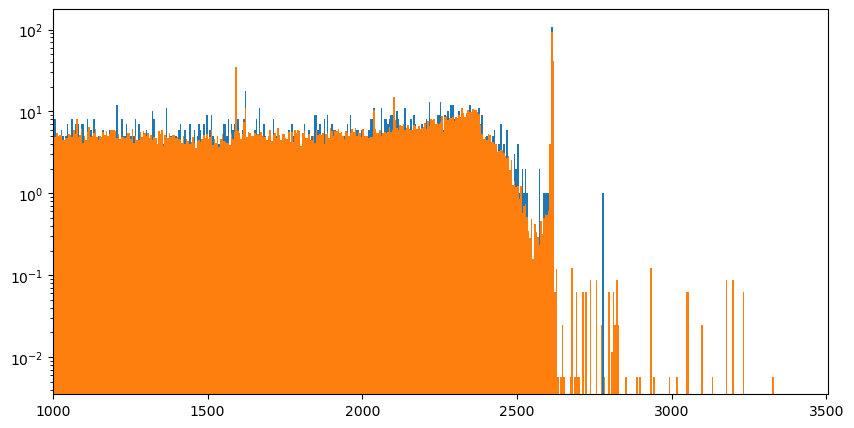

In [31]:
fitted_hist = hypothesis(result)
plt.figure(figsize=(10, 5))
plt.stairs(selected_hist_Target, bins_Target, label='Target', fill=True)
plt.stairs(fitted_hist, bins_Target, label='Fitted', fill=True)
plt.yscale('log')
plt.xlim(energy_lower_limit, energy_upper_limit + bin_width)


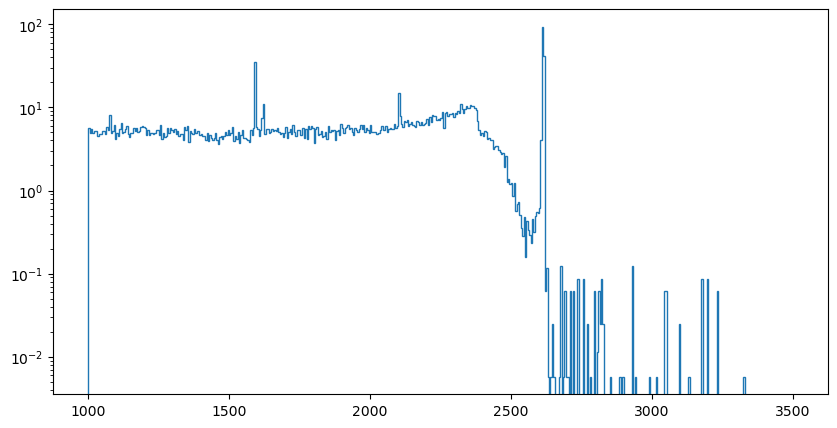

In [34]:
asimov_hist = result[0] * pdf_A + result[1] * pdf_B + result[2] * pdf_C

plt.figure(figsize=(10, 5))
plt.stairs(asimov_hist, bins_Target)
plt.yscale('log')
plt.show()

In [67]:
# new functions for asimov data
def hypothesis_asimov(theta):
    return result[0] * pdf_A + result[1] * pdf_B + result[2] * pdf_C + theta * pdf_N

def log_likelihood_asimov(theta, target_hist):
    mu = hypothesis_asimov(theta)
    non_zero_bins = target_hist[(target_hist > 0) & (mu > 0)]
    non_zero_bins_mu = mu[(target_hist > 0) & (mu > 0)]
    zero_bins_mu = mu[~(target_hist > 0) & ~(mu > 0)]
    return np.sum(non_zero_bins * np.log(non_zero_bins_mu) - non_zero_bins_mu - non_zero_bins * np.log(non_zero_bins) + non_zero_bins) - np.sum(zero_bins_mu)
    
def log_prior_asimov(theta):
    # Use Jeffreys prior for Poisson distribution for theta_N
    prior = - np.log(theta) / 2
    return prior

def log_posterior_asimov(theta, target_hist):
    # Use the log-likelihood and log-prior to compute the log-posterior
    posterior = log_likelihood_asimov(theta, target_hist) + log_prior_asimov(theta)
    if np.any(theta < 0):
        return -np.inf
    return posterior

In [61]:
theta_est

array([1349.59022283,  769.59245575,  999.59252396,  999.01283523])

In [70]:
# run mcmc on the asimov dataset
ovbb = 0
n_walkers = 100
initial_theta_asimov = ovbb + 0.1 * np.random.randn(n_walkers, 1)

sampler_asimov = emcee.EnsembleSampler(n_walkers, 1, log_posterior_asimov, args=[asimov_hist])

In [71]:
sampler_asimov.run_mcmc(initial_theta_asimov, 5000, progress=True)

/tmp/ipykernel_499/2984133817.py:14: RuntimeWarning: invalid value encountered in log
  prior = - np.log(theta) / 2
  0%|          | 0/5000 [00:00<?, ?it/s]/home/ssimonai/.local/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:31<00:00, 158.63it/s]


State([[3.42346717e-01]
 [1.97217576e+00]
 [1.15365957e-02]
 [1.43206126e+00]
 [3.03062499e-01]
 [9.03654504e-02]
 [2.07653123e+00]
 [4.79691485e-02]
 [5.63646919e-01]
 [5.57320331e-01]
 [2.94110557e-01]
 [6.35641921e-01]
 [2.49283788e+00]
 [3.14277185e-01]
 [2.27839686e-02]
 [3.87170205e-01]
 [1.67509366e-01]
 [1.46358648e-01]
 [3.22693223e+00]
 [3.11318160e+00]
 [2.70751206e+00]
 [1.10617201e+00]
 [4.96147662e+00]
 [1.69657245e+00]
 [1.59946117e-02]
 [5.50261859e+00]
 [1.26042365e-01]
 [1.52291091e+00]
 [1.09039612e-01]
 [2.55743784e+00]
 [2.27181904e+00]
 [1.43194596e+00]
 [4.45338404e-01]
 [3.28536094e+00]
 [6.82821117e-01]
 [2.11703027e+00]
 [4.35087170e-01]
 [5.52799802e-01]
 [5.05296152e+00]
 [1.44001368e+00]
 [1.30490044e+00]
 [1.74973123e-01]
 [3.95083342e+00]
 [5.81630390e-01]
 [6.06031345e+00]
 [1.83223097e-02]
 [4.96943484e+00]
 [5.44674792e-02]
 [3.14819475e+00]
 [1.56930871e-02]
 [5.02799751e+00]
 [1.34593519e-01]
 [2.40832583e-01]
 [2.05788285e-01]
 [3.30178961e-02]
 [8.

In [74]:
samples.shape

(5000, 100, 4)

In [75]:
samples_asimov.shape

(5000, 100, 1)

Text(0.5, 0, 'step number')

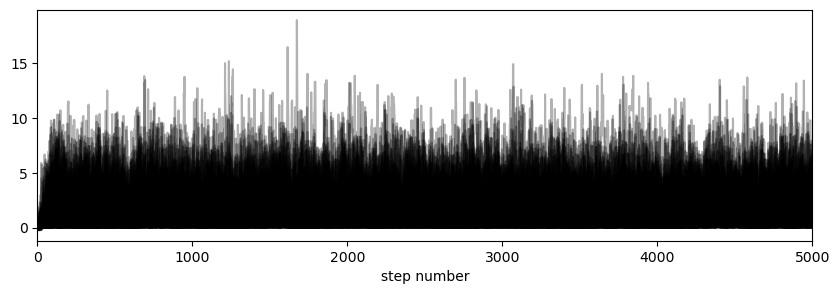

In [83]:
fig, axes = plt.subplots(1, figsize=(10, 3), sharex=True)
samples_asimov = sampler_asimov.get_chain()
labels = ["A", "B", "C", "N"]

ax = axes
ax.plot(samples_asimov[:, :, 0], "k", alpha=0.3)
ax.set_xlim(0, len(samples_asimov))
#ax.yaxis.set_label_coords(-0.1, 0.5)

axes.set_xlabel("step number")

In [84]:
sampler_asimov.get_autocorr_time()

array([45.45620961])

In [85]:
flat_samples_asimov = sampler_asimov.get_chain(discard=200, flat=True)
print(flat_samples_asimov.shape)

(480000, 1)


In [90]:
mcmc_asimov = np.percentile(flat_samples_asimov[:, 0], [16, 50, 84])
q = np.diff(mcmc_asimov)
txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt = txt.format(mcmc_asimov[1], q[0], q[1], 'N_{A}')
result_asimov = mcmc_asimov[1]
display(Math(txt))

<IPython.core.display.Math object>

In [89]:
ES = np.percentile(flat_samples_asimov[:, 0], 90)  # experimental sensitivity
CI = np.percentile(flat_samples[:, 3], 90)  # 90% credible interval
print(ES)
print(CI)

3.7040219055600896
10.112510527654779


"ES" is the experimental sensitivity, or 90% median sensitivity; "CI" is the Bayes 90% credible interval, or experimental confidence limit. Since our experimental confidence limit is greater than the 90% median sensitivity, we have overfluctuation, meaning we've obtained a stronger result (in practice) than the minimum detectable level [from the toy Asimov data, assuming no $0 \nu \beta \beta$ decay events]; given that some $m$ number of $0 \nu \beta \beta$ decay events have been artificially injected, this makes sense (and is expected, even).